In [1]:
import sympy as sp
import numpy as np
import pandas as pd
import scipy.signal as ss
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# core functions

In [3]:
# interrogating signal
def g_signal(t, w=2*np.pi):
    return (np.cos(w * t) -
            np.cos(1.2 * w * t) +
            np.cos(1.4 * w * t) -
            np.cos(1.6 * w * t) +
            np.cos(1.8 * w * t) -
            np.cos(2.0 * w * t))

# gaussian mixture model scatterer
def s_gmm(p, t):
    a1, l1, l2, s = p
    g1 = a1 * np.exp(-0.5 * ((t - l1) / s)**2)
    g2 = (1. - a1) * np.exp(-0.5 * ((t - l2) / s)**2)
    s_n = g1 + g2
    return s_n / np.sum(s_n)

# "delta function" scatterer
# delta functions don't work well with derivatives, jacobians, et.
# so we use very narrow gaussians to approximate them
def s_delta(p, t, s=3e-4):
    a1, a2, a3, l1, l2, l3 = p
    g1 = a1 * np.exp(-0.5 * ((t - l1) / s)**2)
    g2 = a2 * np.exp(-0.5 * ((t - l2) / s)**2)
    g3 = a3 * np.exp(-0.5 * ((t - l3) / s)**2)
    s_n = g1 + g2 + g3
    return s_n / np.sum(s_n)

# "delta function" scatterer with only two deltas rather than three
def s_delta_2(p, t, s=3e-4):
    a1, a2, l1, l2 = p
    g1 = a1 * np.exp(-0.5 * ((t - l1) / s)**2)
    g2 = a2 * np.exp(-0.5 * ((t - l2) / s)**2)
    s_n = g1 + g2
    return s_n / np.sum(s_n)

# finds and returns the moments of the scatterer distribution
def get_s_moments(func, p, t):
    s_n         = func(p, t)
    area        = np.sum(s_n)
    mean        = np.sum(t * s_n) / area
    var         = np.sum(((t - mean)**2) * s_n) / area
    std         = np.sqrt(var)
    skew        = np.sum((((t - mean) / std)**3) * s_n) / area
    kurt        = np.sum((((t - mean) / std)**4) * s_n) / area
    return np.array([mean, std, skew, kurt])

# returns an array representing the impact of each parameter on r_n
def get_dr_dtheta(func, g_n, p, t, epsilon=1e-14):
    num_params  = len(p)
    dr_dtheta   = []
    for i in range(num_params):
        p_plus      = np.array(p, dtype=float)
        p_minus     = np.array(p, dtype=float)
        d_p         = np.abs(p[i]) * epsilon if p[i] != 0 else epsilon
        # d_p         = epsilon
        p_plus[i]  += d_p
        p_minus[i] -= d_p
        s_n_plus    = func(p_plus, t)
        s_n_minus   = func(p_minus, t)
        r_n_plus    = ss.convolve(s_n_plus, g_n, mode='same')
        r_n_minus   = ss.convolve(s_n_minus, g_n, mode='same')
        derivative  = (r_n_plus - r_n_minus) / (2 * d_p)
        dr_dtheta.append(derivative)
    return dr_dtheta

# fisher information matrix for parameters theta given return signal, noise, etc.
def calculate_fim_theta(r_n, dr_dtheta, theta, snr_db=0):
    signal_power    = np.mean(r_n**2)
    snr_linear      = 10**(snr_db / 10.0)
    noise_var       = signal_power / snr_linear
    fim             = np.zeros((len(theta), len(theta)))
    for i in range(len(theta)):
        for j in range(i, len(theta)):
            dot_product = dr_dtheta[i] * dr_dtheta[j]
            fim[i, j]   = (1.0 / noise_var) * np.sum(dot_product)
            fim[j, i]   = fim[i, j]
    return fim

# transform matrix that turns the basis of parameters theta into the basis of moments
def get_jacobian(func, p, t, epsilon=1e-14):
    jacobian    = np.zeros((4, len(p)))
    for i in range(len(p)):
        p_plus          = p.copy()
        p_minus         = p.copy()
        d_p             = np.abs(p[i]) * epsilon if p[i] != 0 else epsilon
        # d_p             = epsilon
        p_plus[i]      += d_p
        p_minus[i]     -= d_p
        moments_plus    = get_s_moments(func, p_plus, t)
        moments_minus   = get_s_moments(func, p_minus, t)
        jacobian[:, i]  = (moments_plus - moments_minus) / (2 * d_p)
    return jacobian

# tests and reports

In [88]:
samp_rate       = 1000
dt              = 1/samp_rate
t               = np.arange(-2.5, 2.5, dt)
t_g             = np.arange(-5, 5, dt)
g_n             = g_signal(t_g)
snr_db          = 20
delta           = True
epsilon         = 1e-8

if delta:
    func        = s_delta
    params = {'amp1': 0.05, 'amp2': 0.05, 'amp3': 0.9,
                   'loc1': -0.02, 'loc2': 0.00, 'loc3': 0.02}
else:
    func        = s_gmm
    params = {'amp1': 0.5, 'loc1': -0.1,
                   'loc2': 0.1, 'sigma': 0.05}

theta           = np.array(list(params.values()))
s_n             = func(theta, t)
dr_dtheta       = get_dr_dtheta(func, g_n, theta, t)
jacobian        = get_jacobian(func, theta, t, epsilon=epsilon)
r_n             = ss.convolve(s_n, g_n, mode='same')
fim_theta       = calculate_fim_theta(r_n, dr_dtheta, theta, snr_db)
crlb_theta      = np.linalg.inv(fim_theta)
crlb_moments    = jacobian @ crlb_theta @ jacobian.T
crlb            = np.sqrt(np.diag(crlb_moments))

print(crlb)

[1.43367033e-04 4.48989144e-04 2.46611522e-01 1.77859700e+00]


In [84]:
eigvals = np.linalg.eigvals(fim_theta)
print("FIM eigenvalues:", eigvals)

FIM eigenvalues: [1.53190805e+06 4.57324758e+05 2.26557126e+02 3.24383548e+04
 1.82147126e+04 7.13407671e+04]


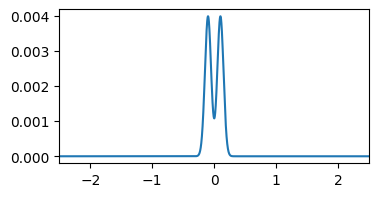

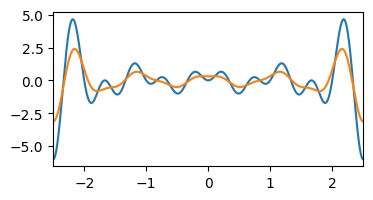

In [ ]:
plt.rcParams['figure.figsize'] = [4, 2]
plt.rcParams['figure.dpi'] = 100

plt.plot(t, s_n)
plt.xlim(-2.5, 2.5)
plt.show()

plt.plot(t_g, g_n)
plt.plot(t, r_n)
plt.xlim(-2.5, 2.5)
plt.show()

# create database entries

In [4]:
folder = '/content/drive/MyDrive/Chapman/Research/RADAR/Derek/Scatter_Distribution/'

In [8]:
db      = pd.read_csv(folder + 'db_delta_snr10_w_preds2.csv')
db2     = pd.read_csv(folder + 'db_norm_snr10_w_preds2.csv')

In [10]:
def find_all_crlb_for_database(db, delta=True):
    samp_rate           = 1000
    dt                  = 1/samp_rate
    t                   = np.arange(-2.5, 2.5, dt)
    t_g                 = np.arange(-5, 5, dt)
    g_n                 = g_signal(t_g)
    snr_db              = 20
    epsilon             = 1e-8

    if delta:
        if db['amp_3'] == 0.:
            func        = s_delta_2
            params = {'amp1': db['amp_1'], 'amp2': db['amp_2'], 'loc1': db['loc_1'], 'loc2': db['loc_2']}
        else:
            func        = s_delta
            params = {'amp1': db['amp_1'], 'amp2': db['amp_2'], 'amp3': db['amp_3'],
                            'loc1': db['loc_1'], 'loc2': db['loc_2'], 'loc3': db['loc_3']}
    else:
        func            = s_gmm
        params     = {'amp1': db['w1'], 'loc1':db['mu1'], 'loc2': db['mu2'], 'sigma': db['sigma']}
    theta               = np.array(list(params.values()))
    s_n                 = func(theta, t)
    dr_dtheta           = get_dr_dtheta(func, g_n, theta, t)
    jacobian            = get_jacobian(func, theta, t, epsilon=epsilon)
    r_n                 = ss.convolve(s_n, g_n, mode='same')
    fim_theta           = calculate_fim_theta(r_n, dr_dtheta, theta, snr_db)

    try:
        crlb_theta      = np.linalg.inv(fim_theta)
        crlb_moments    = jacobian @ crlb_theta @ jacobian.T
        crlb            = np.sqrt(np.diag(crlb_moments))
        return crlb
    except np.linalg.LinAlgError:
        print(params)
        return [np.nan for _ in range(4)]

In [11]:
db[['mean_crlb', 'std_crlb', 'skew_crlb', 'kurtosis_crlb']] = db.apply(lambda x:
                                                                           find_all_crlb_for_database(x, delta=True),
                                                                           axis=1,
                                                                           result_type='expand')

In [12]:
db.to_csv(folder + 'db_delta_snr10_w_preds2_crlb.csv')

In [13]:
db2[['mean_crlb', 'std_crlb', 'skew_crlb', 'kurtosis_crlb']] = db2.apply(lambda x:
                                                                             find_all_crlb_for_database(x, delta=False),
                                                                             axis=1,
                                                                             result_type='expand')

{'amp1': np.float64(0.5499224289273543), 'loc1': np.float64(-0.1200679451657273), 'loc2': np.float64(-9.248481212293429e-06), 'sigma': np.float64(0.001)}
{'amp1': np.float64(0.3001048167036783), 'loc1': np.float64(-0.0802598397138414), 'loc2': np.float64(3.1412469486623545e-06), 'sigma': np.float64(0.0010005413255334)}
{'amp1': np.float64(0.8000209920916099), 'loc1': np.float64(-8.269540581295861e-06), 'loc2': np.float64(0.1200572903545913), 'sigma': np.float64(0.001)}
{'amp1': np.float64(0.4999946482200789), 'loc1': np.float64(-8.153398194538311e-07), 'loc2': np.float64(0.1599590333495395), 'sigma': np.float64(0.001)}
{'amp1': np.float64(0.0001), 'loc1': np.float64(0.1987895995398381), 'loc2': np.float64(-0.199972614939979), 'sigma': np.float64(0.0288733053465238)}
{'amp1': np.float64(0.2279059995010857), 'loc1': np.float64(-0.1755614600979302), 'loc2': np.float64(2.711877187512557e-05), 'sigma': np.float64(0.0324791219990036)}
{'amp1': np.float64(0.9999), 'loc1': np.float64(-0.118010

In [14]:
db2.to_csv(folder + 'db_norm_snr10_w_preds2_crlb.csv')

### tests

In [ ]:
# print a list of all records in db2 whose "mean_crlb" column is not a number

db = pd.read_csv(folder + 'db_delta_snr10_w_preds2_crlb.csv')
db2 = pd.read_csv(folder + 'db_norm_snr10_w_preds2_crlb.csv')

In [ ]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 687800 entries, 0 to 687799
Data columns (total 47 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     687800 non-null  int64  
 1   loc_1          687800 non-null  float64
 2   loc_2          687800 non-null  float64
 3   loc_3          687800 non-null  float64
 4   amp_1          687800 non-null  float64
 5   amp_2          687800 non-null  float64
 6   amp_3          687800 non-null  float64
 7   mean           687800 non-null  float64
 8   variance       687800 non-null  float64
 9   std            687800 non-null  float64
 10  skew           687800 non-null  float64
 11  kurtosis       687800 non-null  float64
 12  inv_kurt       687800 non-null  float64
 13  hyperskewness  687800 non-null  float64
 14  hyperkurtosis  687800 non-null  float64
 15  segment0_0     687800 non-null  float64
 16  segment0_1     687800 non-null  float64
 17  segment0_2     687800 non-nul

In [ ]:
db2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 687800 entries, 0 to 687799
Data columns (total 45 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     687800 non-null  int64  
 1   mu1            687800 non-null  float64
 2   mu2            687800 non-null  float64
 3   sigma          687800 non-null  float64
 4   w1             687800 non-null  float64
 5   mean           687800 non-null  float64
 6   variance       687800 non-null  float64
 7   std            687800 non-null  float64
 8   skew           687800 non-null  float64
 9   kurtosis       687800 non-null  float64
 10  inv_kurt       687800 non-null  float64
 11  hyperskewness  687800 non-null  float64
 12  hyperkurtosis  687800 non-null  float64
 13  segment0_0     687800 non-null  float64
 14  segment0_1     687800 non-null  float64
 15  segment0_2     687800 non-null  float64
 16  segment0_3     687800 non-null  float64
 17  segment0_4     687800 non-nul